In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.cm as cm
from sklearn import datasets
from math import *
from losses.label_smoothing import CrossEntropyLoss
from rtpt import RTPT

import seaborn as sns; sns.set_style('white')

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 5)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['lines.linewidth'] = 1.0
plt = matplotlib.pyplot

(-15.0, 15.0)

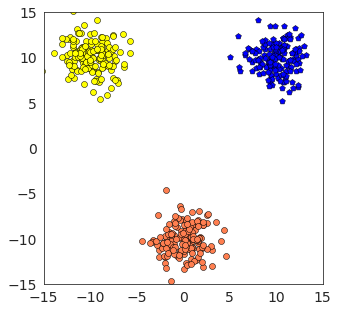

In [3]:
# Generate data
np.random.seed(7777)
size = 500
train_range = (-10, 10)

X_train, Y_train = datasets.make_blobs(n_samples=size,
                           centers=[[0, -10], [-10, 10], [10, 10]],
                           cluster_std=1.6,
                           center_box=train_range,
                           random_state=17)

# Test data
test_range = (-15, 15)

size = 100
test_range = (-15, 15)
test_rng = np.linspace(*test_range, size)

X1_test, X2_test = np.meshgrid(test_rng, test_rng)
X_test = np.stack([X1_test.ravel(), X2_test.ravel()]).T
X_test = torch.from_numpy(X_test).float()


plt.scatter(X_train[Y_train == 0][:, 0],
            X_train[Y_train == 0][:, 1],
            c='coral',
            edgecolors='k',
            linewidths=0.5)
plt.scatter(X_train[Y_train == 1][:, 0],
            X_train[Y_train == 1][:, 1],
            c='yellow',
            edgecolors='k',
            linewidths=0.5)
plt.scatter(X_train[Y_train == 2][:, 0],
            X_train[Y_train == 2][:, 1],
            c='blue',
            marker='p',
            edgecolors='k',
            linewidths=0.5)
plt.xlim(test_range)
plt.ylim(test_range)

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        torch.manual_seed(42)
        self.model = nn.Sequential(nn.Linear(2, 20),
                                          nn.BatchNorm1d(20),
                                          nn.ReLU(),
                                          nn.Linear(20, 20),
                                          nn.BatchNorm1d(20),
                                          nn.ReLU(), 
                                          nn.Linear(20, 3, bias=False))

    def forward(self, x):
        x = self.model(x)
        return x

def train(model, X, Y, alpha):
    X_train = torch.from_numpy(X).float().cuda()
    y_train = torch.from_numpy(Y).long().cuda()

    model = model.cuda()
    opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    loss_fkt = CrossEntropyLoss(label_smoothing=alpha)
    for it in range(5000):
        y = model(X_train)
        loss = loss_fkt(y, y_train)
        loss.backward()
        opt.step()
        opt.zero_grad()

    print(f'Loss: {loss.item():.4f}')

In [5]:
def compute_conf(model, X_test):
    model.eval()
    with torch.no_grad():
        conf_map = F.softmax(model(X_test.cuda()), 1).squeeze().cpu().numpy()
        conf = conf_map.max(1)
    return conf

def compute_route(model, X_train, Y_train, target_cls=2, initial_point=[-3, -10], max_steps=10000, target_conf=0.95):
    initial_point = torch.tensor([initial_point]).float().cuda()
    target = torch.tensor([target_cls]).cuda()
    optimizer = optim.SGD([initial_point.requires_grad_()], lr=0.1, momentum=0.0)
    points = [initial_point.clone().detach()]
    grad_list = []

    for step in range(max_steps):
        output = model(initial_point.requires_grad_())
        loss = F.cross_entropy(output, target)
        optimizer.zero_grad()
        model.zero_grad()
        loss.backward()
        grad = initial_point.grad
        grad_list.append(grad.clone().detach().norm().cpu().item())
        optimizer.step()
        points.append(initial_point.clone().detach())
        if output.softmax(1)[0, target_cls] > target_conf:
            break
    steps_required = step
    closest_sample_dist = torch.min(torch.norm(torch.tensor(X_train[Y_train == 2]) - initial_point.cpu(), dim=1))
    points = torch.cat(points).cpu()
    return points, steps_required, closest_sample_dist

In [6]:
def plot(X, Y, X1_test, X2_test, Z, test_range, title=None, points=None, file_name=None, colorbar=False):
    plt.figure(figsize=(6, 5))
    if title is not None:
        plt.title(title)

    im = plt.contourf(X1_test,
                      X2_test,
                      Z,
                      alpha=0.7,
                      cmap='RdPu',
                      levels=np.arange(0.0, 1.01, 0.05))
    if colorbar:
        plt.colorbar(im, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

    plt.scatter(X[Y == 0][:, 0],
                X[Y == 0][:, 1],
                c='#69c765',
                marker='o',
                edgecolors='k',
                linewidths=0.5)
    plt.scatter(X[Y == 1][:, 0],
                X[Y == 1][:, 1],
                c='#5cd0f7',
                marker='s',
                edgecolors='k',
                linewidths=0.5)
    plt.scatter(X[Y == 2][:, 0],
                X[Y == 2][:, 1],
                c='#fcc947',
                marker='p',
                s=50,
                edgecolors='k',
                linewidths=0.8)
    if points is not None:
        plt.plot(points[:, 0], points[:, 1], '-o', c='yellow', linewidth=4.0, markersize=0.0)
        # for i in [0, -1]:
        #     plt.scatter([points[i, 0]], [points[i, 1]], linewidths=3, marker='X', c='#80FF00', edgecolor='black', s=500, zorder=1)
    plt.xlim(test_range)
    plt.ylim(test_range)
    plt.xticks([])
    plt.yticks([])
    if file_name is not None:
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.show()

Loss: 0.0021


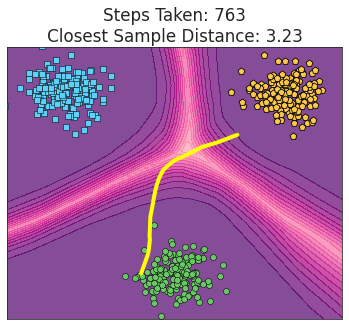

Loss: 0.1698


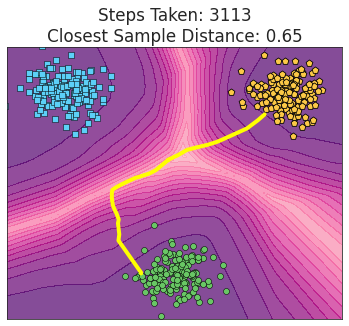

Loss: -1.7280


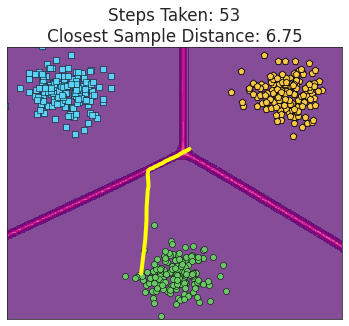

In [7]:
alpha_list = [0.0, 0.05, -0.05]
for alpha in alpha_list:
    model = Model().cuda()
    train(model, X_train, Y_train, alpha=alpha)
    conf = compute_conf(model, X_test)
    points, steps_required, closest_sample_dist = compute_route(model, X_train, Y_train, target_cls=2, initial_point=[-3, -10], max_steps=10000, target_conf=0.95)

    plot(
    X_train,
    Y_train,
    X1_test,
    X2_test,
    conf.reshape(size, size),
    test_range,
    title=
    f'Steps Taken: {steps_required}\nClosest Sample Distance: {closest_sample_dist:.2f}',
    points=points,
    file_name=f'toy_{alpha}.pdf')